# Lab 3: Multi-modal and Multi-task

**Group Members:**
* Clay Harper
* Eli Laird

In this report, we were to choose a dataset where a multi-modal model (multiple input streams), multi-task model (multiple predictive tasks), or both could be created.  We decided to use the 2018 OpenMic dataset because some of Clay's research is based in audio processing, and Eli has in interest in breaking into this field.  

## Dataset Overview

The 2018 OpenMic dataset [1] was created in a collaboration effort between Spotify and MARL@NYU (Music and Audio Research Laboratory New York University).

### Classification Task

The classification task is to determine what instruments are present in the audio clip.  Each audio clip may contain multiple instruments, so the task is to determine all instruments present in the clip.  The classification labels are:

* accordion
* banjo
* bass
* cello
* clarinet
* cymbals
* drums
* flute
* guitar
* mallet_percussion
* mandolin
* organ
* piano
* saxophone,
* synthesizer
* trombone
* trumpet
* ukulele
* violin
* voice

Each audio clip has been labeled by a variety of people on which instruments are present in the clip.  Each person, depending on their area of expertise, is given a `worker_trust` score--so a piano player will get a high trust on identifying if there is a piano but maybe a lower trust in identifying a ukulele.  From that, a `relevance_score` is computed by a weighted sum of the `worker_trust` and the `label` (1 or 0) if the instrument was present.  Essentially, each audio clip is given a `relevance_score` for each instrument.  `relevance_score` is basically a confidence score for how likely this instrument appears in the audio clip.

### Feature Data Format

There are multiple options we can do for the feature data.  The data archive includes both raw audio files in the form of `.ogg` files and pre-computed VGGish Features [3].  If we wanted, we could featurize of the `.ogg` files by using the raw amplitude values, use MFCCs, CQT, etc.  For simplicity in this lab, we have decided to just use the VGGish features provided.   


### Mulit-Modal/Multi-Task/Both?

We thought about making this project be both multi-modal and multi-task, but since we are using the VGGish Features, we decided to just make this project muli-task where the tasks are identifying each instrument in the audio clip separately.

### Who Collected the Data?

Spotify and MARL@NYU (Music and Audio Research Laboratory New York University).  The cost of annotation was sponsored by Spotify.

#### Why was the Data Collected?

The idea was to create a dataset that can be used in music information retrieval through identifying different instruments in an audio clip.  Some applications of music information retrieval are music genre classification, recommender systems, music separation, automatic music transcription, music generation, and more [2]. To give an example of how this dataset could help Spotify, think of a user who wants to listen to piano music on a long day.  The user could go to the search bar on Spotify and type in piano.  In order to get good results, the Spotify must have piano tags associated with songs to return piano music.  This process of tagging can be very labor intensive and expensive because people have to listen to a song, identify it as piano music, and tag the song in the database.  This is increasingly difficult when more songs are constantly added to Spotify's database.  Instead, if we can create a model that is very good at listening to music and segmenting out the types of instruments in the music, we can help automate this process (also VGGish was developed by Google so...).  VGGish features are computed using a pre-trained CNN from Google based on [3], which essentially uses a very similar architecture to the VGG image classification architecture.  In total, there are 17 layers containing convolutional layers, activations, followed by maxpooling operations.  In the OpenMic version, VGGish Features are computed on an embedding layer in the VGGish archtitecture and then projected down to a _____ dimensional space using PCA. 

#### When was the Data Collected?

The data was collected and put together in 2018.

### Evaluation Criteria

We thought about discretizing the `relevance_score` by some threshold (say .5) and making this a binary classification problem for each instrument.  Instead, we decided to regress the `relevance_score` for each instrument because this allows for more post-processing, particularly in an example discussed above with a user searching for piano music.  If we used a threshold of .5, a `relevance_score` of .51 would mean that, yes, a piano appears in this audio clip.  Well, maybe the piano just appears for a breif amount of time in the audio clip and that's why it had a relatively low confidence score.  The user searching for piano music would likely want songs that are very piano-based--that's why they probably searched `piano`.  Regressing the relevance score instead would allow better post-processing where maybe we can sort the search results from highest to lowest `relevance_score` so the user is happier with the search results.

 


[1] Humphrey, Eric J., Durand, Simon, and McFee, Brian. "OpenMIC-2018: An Open Dataset for Multiple Instrument Recognition." in Proceedings of the 19th International Society for Music Information Retrieval Conference (ISMIR), 2018.

[2] https://en.wikipedia.org/wiki/Music_information_retrieval#:~:text=Music%20information%20retrieval%20(MIR)%20is,with%20many%20real%2Dworld%20applications.

[3] Shawn Hershey, Sourish Chaudhuri, Daniel P. W. Ellis, Jort F. Gemmeke, Aren Jansen, Channing Moore, Manoj Plakal, Devin Platt, Rif A. Saurous, Bryan Seybold, Malcolm Slaney, Ron Weiss, & Kevin Wilson (2017). CNN Architectures for Large-Scale Audio Classification. In International Conference on Acoustics, Speech and Signal Processing (ICASSP).

## How many tasks or modalities are there in the dataset and how do you define each task or modality?

There are 20 tasks (1 for each instrument), and there is 1 modality (the VGGish Feature).  

****domains/cross domains

**BEWARE**
* TF2.0.0 isn't compatable with python > 3.7
* Must use TF2.0.0 for maneframe

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, ShuffleSplit
import pandas as pd
import json
import os

In [2]:
print("TF Version: ", tf.__version__)

TF Version:  2.0.0


In [3]:
datadir = '../data'
openmic_file_dir = os.path.join(datadir, 'openmic-2018')

## Load In Data

In [4]:
with np.load(os.path.join(openmic_file_dir, 'openmic-2018.npz'), allow_pickle=True) as data:
    files = data.files
    print(f'The data files are: {files}')
    
    x_total = data['X']
    y = data['Y_true']
#     y[y == .5] = 0 # weird dataset (.5 only occurs with their 50/50 shot--not ever a relevance score)
    # Call it a soft-no since it appears in the individual df but not in the label df
    y_mask = data['Y_mask']
    sample_keys = data['sample_key']

print(f'Data shape: {x_total.shape}')
print(f'True label shape: {y.shape}')
print(f'True label mask shape: {y_mask.shape}')
print(f'Total samples: {sample_keys.shape}')

with open(os.path.join(openmic_file_dir, 'class-map.json'), 'r') as f:
    class_map = json.load(f)
class_map

The data files are: ['X', 'Y_true', 'Y_mask', 'sample_key']
Data shape: (20000, 10, 128)
True label shape: (20000, 20)
True label mask shape: (20000, 20)
Total samples: (20000,)


{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

### Split Into Train/Test

**We can talk about this more later, could do 80/20 split-probably should do cross validation**

**Using their split for now**

**Well,...they have their own split.  Not sure if this is what Dr. Larson wants though**

* Should be useful:
    * https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb

In [5]:
total_idexes = list(range(len(sample_keys)))
k_folds = 5
# Use for later when training datasets
splitter = ShuffleSplit(n_splits=5, test_size=.2)

In [6]:
# If we use their split
split_train = pd.read_csv(os.path.join(openmic_file_dir, 'partitions/split01_train.csv'), 
                          header=None, squeeze=True)
split_test = pd.read_csv(os.path.join(openmic_file_dir,'partitions/split01_test.csv'), 
                         header=None, squeeze=True)

print(f'Train samples: {len(split_train)} test samples: {len(split_test)}')

Train samples: 14915 test samples: 5085


In [37]:
split_test[0]

'000178_3840'

In [14]:
sample_key_df = pd.DataFrame({'sample_key': sample_keys})
sample_key_df['index'] = sample_key_df.index
train_keys_df = pd.DataFrame({'sample_key': split_train})
test_keys_df = pd.DataFrame({'sample_key': split_test})

# Get the train and test indexes according to their split
train_idxs = np.array(train_keys_df.merge(sample_key_df, on='sample_key', how='left')['index'])
test_idxs = np.array(test_keys_df.merge(sample_key_df, on='sample_key', how='left')['index'])

# Split the train/test data
x_train, x_test = x_total[train_idxs], x_total[test_idxs]
y_train, y_test = y[train_idxs], y[test_idxs]

In [20]:
x_train.shape

(14915, 10, 128)

In [28]:
x_test.shape

(5085, 10, 128)

## Add MFCCs

In [9]:
%%time
from librosa import load as load_audio
from librosa.feature import mfcc as create_mfcc
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import glob, os, shutil

# Create place to save mfcc
src = os.path.join(openmic_file_dir, 'audio/')
dest = os.path.join(openmic_file_dir, 'npy_audio/')

def copy_tree(src, dest):
    
    def ig_f(dir, files):
        return [f for f in files if os.path.isfile(os.path.join(dir, f))]
    
    if os.path.exists(dest):
        print('Destination Root File Already Exists')
    else:
        shutil.copytree(src, dest, ignore=ig_f)
        
copy_tree(src, dest)

Destination Root File Already Exists
CPU times: user 379 ms, sys: 117 ms, total: 496 ms
Wall time: 673 ms


In [12]:
file_list = glob.glob(src + '**/*.ogg', recursive=True)

In [38]:
len(file_list)

20000

In [14]:
def make_mfcc(file_chunk):
    for file in tqdm(file_chunk, position=0, leave=True):
        sr = 8000
        audio, sr = load_audio(file, sr=sr)
        clip_path = '/'.join(file.split('/')[-2:])
        clip_path = dest + clip_path.split('.')[0] + '.npy'
        np.save(clip_path, create_mfcc(audio, sr=sr, n_mfcc=20))
    
file_list = glob.glob(src + '**/*.ogg', recursive=True)

max_workers = os.cpu_count()
chunked_file_list = np.array_split(file_list, max_workers)

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    _ = list(tqdm(executor.map(make_mfcc, chunked_file_list), total=len(chunked_file_list), 
                       position=0, leave=True))

100%|██████████| 12/12 [37:37<00:00, 188.15s/it]


In [15]:
train_npy_df = pd.DataFrame({'path': file_list})

def get_sample_key(x):
    base = x.split('/')[-1]
    return base.split('.')[0]

def fix_path(x):
    clip_path = '/'.join(x.split('/')[-2:])
    return dest + clip_path.split('.')[0] + '.npy'

train_npy_df['sample_key'] = train_npy_df['path'].apply(get_sample_key)
train_npy_df['path'] = train_npy_df['path'].apply(fix_path)
train_npy_df = train_keys_df.merge(train_npy_df, on='sample_key', how='left')
train_npy_df

,sample_key,path
0,000046_3840,../data/openmic-2018/npy_audio/000/000046_3840...
1,000135_483840,../data/openmic-2018/npy_audio/000/000135_4838...
2,000139_119040,../data/openmic-2018/npy_audio/000/000139_1190...
3,000141_153600,../data/openmic-2018/npy_audio/000/000141_1536...
4,000144_30720,../data/openmic-2018/npy_audio/000/000144_3072...
...,...,...
14910,155294_184320,../data/openmic-2018/npy_audio/155/155294_1843...
14911,155295_76800,../data/openmic-2018/npy_audio/155/155295_7680...
14912,155307_211200,../data/openmic-2018/npy_audio/155/155307_2112...
14913,155310_372480,../data/openmic-2018/npy_audio/155/155310_3724...


In [39]:
test_npy_df = pd.DataFrame({'path' : file_list})

test_npy_df['sample_key'] = test_npy_df['path'].apply(get_sample_key)
test_npy_df['path'] = test_npy_df['path'].apply(fix_path)
test_npy_df = test_keys_df.merge(test_npy_df, on='sample_key', how='left')
test_npy_df

,sample_key,path
0,000178_3840,../data/openmic-2018/npy_audio/000/000178_3840...
1,000308_61440,../data/openmic-2018/npy_audio/000/000308_6144...
2,000312_184320,../data/openmic-2018/npy_audio/000/000312_1843...
3,000319_145920,../data/openmic-2018/npy_audio/000/000319_1459...
4,000321_218880,../data/openmic-2018/npy_audio/000/000321_2188...
...,...,...
5080,155175_38400,../data/openmic-2018/npy_audio/155/155175_3840...
5081,155176_23040,../data/openmic-2018/npy_audio/155/155176_2304...
5082,155178_0,../data/openmic-2018/npy_audio/155/155178_0.npy
5083,155193_145920,../data/openmic-2018/npy_audio/155/155193_1459...


In [16]:
#train mfccs
mfccs = []
for file in tqdm(train_npy_df['path']):
    mfccs.append(np.load(file, allow_pickle=True))
    
mfccs = np.hstack(mfccs)

100%|██████████| 14915/14915 [00:12<00:00, 1169.87it/s]


In [40]:
#test mfss
mfccs_test = []
for file in tqdm(test_npy_df['path']):
    mfccs_test.append(np.load(file, allow_pickle=True))
    
mfccs_test = np.hstack(mfccs_test)

100%|██████████| 5085/5085 [00:03<00:00, 1274.01it/s]


In [17]:
train_set_mean = np.mean(mfccs, axis=1, keepdims=True)
train_set_std = np.std(mfccs, axis=1, keepdims=True)

In [18]:
# Glorot initialize all mfccs 
npy_file_list = [fix_path(x) for x in file_list]

for file in tqdm(npy_file_list):
    mfccs = np.load(file, allow_pickle=True)
    mfccs = (mfccs-train_set_mean)/train_set_std
    np.save(file, mfccs)

100%|██████████| 20000/20000 [00:32<00:00, 615.19it/s]


In [ ]:
# Glorot initialize all mfccs 
npy_file_list = [fix_path(x) for x in file_list]

for file in tqdm(npy_file_list):
    mfccs = np.load(file, allow_pickle=True)
    mfccs = (mfccs-train_set_mean)/train_set_std
    np.save(file, mfccs)

In [16]:
mfccs_mean_std = []
for file in tqdm(train_npy_df['path']):
    mfccs_mean_std.append(np.load(file, allow_pickle=True))
    
mfccs_mean_std = np.array(mfccs_mean_std)

100%|██████████| 14915/14915 [00:10<00:00, 1403.33it/s]


In [41]:
test_mfccs_mean_std = []
for file in tqdm(test_npy_df['path']):
    test_mfccs_mean_std.append(np.load(file, allow_pickle=True))
    
test_mfccs_mean_std = np.array(test_mfccs_mean_std)

100%|██████████| 5085/5085 [00:01<00:00, 3659.06it/s]


In [33]:
mfccs_mean_std.shape

(14915, 20, 157)

In [42]:
test_mfccs_mean_std.shape

(5085, 20, 157)

**Insert architecture here**

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 10, 128)]    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 10, 128)]    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 20, 157)]    0                                            
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 128)          0           input_11[0][0]                   
____________________________________________________________________________________________

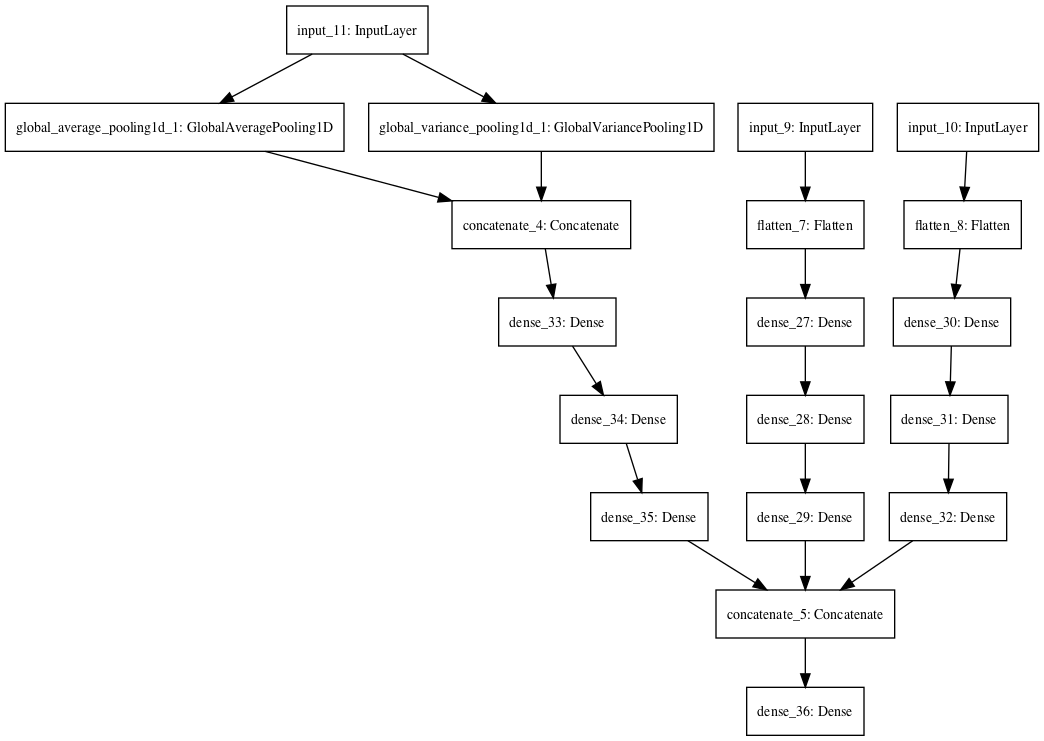

In [29]:
from tensorflow.keras.layers import Flatten, Dense, Input, Layer, GlobalAveragePooling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

def create_nn():
    inputs = Input(shape=(10, 128))
    net = Flatten()(inputs)
    net = Dense(500, activation='relu')(net)
    net = Dense(250, activation='relu')(net)
    net = Dense(100, activation='relu')(net)
    #output = Dense(20, activation='linear')(net)
    
    
    model = Model(inputs, net)
    '''    adam = Adam(1e-4)
    model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae'])'''
    
    return model


class GlobalVariancePooling1D(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        return K.var(x, axis=1)
    
    
def create_nn_x_vec():
    inputs = Input(shape=(10, 128))
    gap = GlobalAveragePooling1D()(inputs)
    gvp = GlobalVariancePooling1D()(inputs)
    net = concatenate([gap, gvp])
    net = Dense(500, activation='relu')(net)
    net = Dense(250, activation='relu')(net)
    net = Dense(100, activation='relu')(net)
    #output = Dense(20, activation='linear')(net)
    
    
    model = Model(inputs, net)
    ''' adam = Adam(1e-4)
    model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae'])'''
    
    return model


def create_mfcc_nn():
    inputs = Input(shape=(20, 157))
    net = Flatten()(inputs)
    net = Dense(500, activation='relu')(net)
    net = Dense(250, activation='relu')(net)
    net = Dense(100, activation='relu')(net)
    
    model = Model(inputs, net)
    
    
    return model

def create_multi_modal_nn():
    m1 = create_nn()
    m2 = create_mfcc_nn()
    m3 = create_nn_x_vec()
    
    net = tf.keras.layers.Concatenate()([m1.output, m2.output, m3.output])
    output = Dense(20, activation='relu')(net)
    
    model = Model(inputs=[m1.input, m2.input, m3.input], outputs=[output])
    
    adam = Adam(1e-4)
    model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae']) 
    
    return model



multi_modal_nn = create_multi_modal_nn()
multi_modal_nn.summary()

plot_model(multi_modal_nn)

## Training

In [50]:
# from tensorflow.data.Dataset import from_tensor_slices
batch_size = 16

# Convert to tf data
train_dataset = tf.data.Dataset.from_tensor_slices(({'train_input_1':x_train,'train_input_2':mfccs_mean_std,'train_input_3':x_train}, y_train)).cache().shuffle(100).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(({'test_input_1':x_test,'test_input_2':test_mfccs_mean_std,'test_input_3':x_test}, y_test)).cache().shuffle(100).batch(batch_size).repeat()

In [51]:
train_dataset

<RepeatDataset shapes: ({train_input_1: (None, 10, 128), train_input_2: (None, 20, 157), train_input_3: (None, 10, 128)}, (None, 20)), types: ({train_input_1: tf.int64, train_input_2: tf.float32, train_input_3: tf.int64}, tf.float64)>

In [57]:

callbacks = [
    ModelCheckpoint(filepath='./models/multi.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=5, min_lr=1e-6),
    EarlyStopping(patience=7)
]

train_steps_per_epoch = len(x_train)//batch_size + len(x_train)%batch_size
val_steps_per_epoch = len(x_test)//batch_size + len(x_test)%batch_size
multi_modal_nn.fit(train_dataset, validation_data=test_dataset,
                    epochs=1000, callbacks=callbacks,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1)

print('='*117)
print('Results:')

_, mse, mae = multi_modal_nn.evaluate(test_dataset, steps=val_steps_per_epoch, verbose=0)
print(f'MSE: {mse:.2f}\tMAE: {mae:.3f}')

Train for 935 steps
Epoch 1/1000
  1/935 [..............................] - ETA: 8:03WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: lr


KeyError: 'input_9'

In [11]:
model = create_nn_x_vec()
callbacks = [
    ModelCheckpoint(filepath='./models/x_vec_dense.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=5, min_lr=1e-6),
    EarlyStopping(patience=7)
]

train_steps_per_epoch = len(x_train)//batch_size + len(x_train)%batch_size
val_steps_per_epoch = len(x_test)//batch_size + len(x_test)%batch_size
model.fit(train_dataset, validation_data=test_dataset,
                    epochs=1000, callbacks=callbacks,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1)

print('='*117)
print('Results:')

_, mse, mae = model.evaluate(test_dataset, steps=val_steps_per_epoch, verbose=0)
print(f'MSE: {mse:.2f}\tMAE: {mae:.3f}')

Train for 935 steps, validate for 330 steps
Epoch 1/1000
935/935 [==============================] - 2s 2ms/step - loss: 14967.6204 - mse: 14980.5889 - mae: 54.5322 - val_loss: 44.7848 - val_mse: 44.8092 - val_mae: 2.0801
Epoch 2/1000
935/935 [==============================] - 2s 2ms/step - loss: 18.5767 - mse: 18.5926 - mae: 1.2146 - val_loss: 9.2180 - val_mse: 9.2231 - val_mae: 0.8276
Epoch 3/1000
935/935 [==============================] - 2s 2ms/step - loss: 3.8687 - mse: 3.8718 - mae: 0.6681 - val_loss: 4.6060 - val_mse: 4.6085 - val_mae: 0.6490
Epoch 4/1000
935/935 [==============================] - 2s 2ms/step - loss: 1.1773 - mse: 1.1781 - mae: 0.5503 - val_loss: 3.2636 - val_mse: 3.2653 - val_mae: 0.5901
Epoch 5/1000
935/935 [==============================] - 2s 2ms/step - loss: 0.5187 - mse: 0.5189 - mae: 0.5063 - val_loss: 2.6178 - val_mse: 2.6182 - val_mae: 0.5588
Epoch 6/1000
935/935 [==============================] - 2s 2ms/step - loss: 0.3055 - mse: 0.3056 - mae: 0.4811 - 